# 🔄 Rotation Invariance Regularization Analysis

This notebook provides comprehensive analysis of the new **Rotation Invariance Regularizer** that enforces rotational symmetry by penalizing `f(g·x) - g·f(x)` where `g` is a randomly sampled rotation matrix.

Key features:
- **Rotation-based regularization** that samples rotation matrices at each gradient step
- **Enhanced vector field visualization** with speed/norm overlays
- **Checkpoint saving** for best models during training
- **Comprehensive sweep** of regularization strengths
- **Comparison with Lie derivative regularization**

In [1]:
# Setup and imports
import sys
sys.path.append('../..')

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from pathlib import Path
import json
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import xfads.utils as utils
import xfads.plot_utils as plot_utils
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

# Our custom modules
from regularized_ssm import RegularizedSSM, create_rotation_vector_field
from regularizers import RotationInvarianceRegularizer, LieDerivativeRegularizer

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# REPRODUCIBILITY: Set all seeds
SEED = 41
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"🌱 All seeds set to {SEED} for reproducibility")

Using device: cpu
🌱 All seeds set to 41 for reproducibility


## 🎯 Enhanced Vector Field Plotting with Speed/Norm Overlays

In [2]:
def plot_vector_field_with_speed_overlay(vector_field_fn, ax, min_xy=-2, max_xy=2, grid_size=50, 
                                        colormap='viridis', speed_alpha=0.4, title=None):
    """
    Plot vector field using standard approach with optional speed overlay as background.
    
    Args:
        vector_field_fn: Function that takes tensor of shape (N, 2) and returns (N, 2)
        ax: Matplotlib axis
        min_xy, max_xy: Domain bounds
        grid_size: Resolution for speed overlay
        colormap: Colormap for speed visualization
        speed_alpha: Transparency of speed heatmap
        title: Plot title
    """
    # Plot standard vector field using existing utility
    plot_utils.plot_two_d_vector_field(vector_field_fn, ax, min_xy=min_xy, max_xy=max_xy)
    
    # Optionally add speed overlay as background
    if speed_alpha > 0:
        # Create grid for speed calculation
        x = np.linspace(min_xy, max_xy, grid_size)
        y = np.linspace(min_xy, max_xy, grid_size)
        X, Y = np.meshgrid(x, y)
        
        # Prepare input for vector field
        grid_points = torch.tensor(
            np.stack([X.flatten(), Y.flatten()], axis=1), 
            dtype=torch.float32
        )
        
        # Evaluate vector field and compute speeds
        with torch.no_grad():
            vectors = vector_field_fn(grid_points).cpu().numpy()
        speeds = np.linalg.norm(vectors, axis=1)
        speeds_grid = speeds.reshape(grid_size, grid_size)
        
        # Add speed heatmap as background with low alpha
        im = ax.contourf(X, Y, speeds_grid, levels=20, cmap=colormap, alpha=speed_alpha, zorder=0)
        
        # Add subtle contour lines
        ax.contour(X, Y, speeds_grid, levels=8, colors='gray', alpha=0.2, linewidths=0.5, zorder=0)
    
    # Styling
    if title:
        ax.set_title(title, fontweight='bold')
    
    return ax


def plot_regularization_heatmap(regularizer, ax, min_xy=-2, max_xy=2, grid_size=50, 
                               colormap='plasma', title=None):
    """
    Plot spatial heatmap of regularization violation.
    
    Args:
        regularizer: Regularizer object with eval_regularizer method
        ax: Matplotlib axis
        min_xy, max_xy: Domain bounds
        grid_size: Resolution of the grid
        colormap: Colormap for visualization
        title: Plot title
    """
    # Create grid
    x = np.linspace(min_xy, max_xy, grid_size)
    y = np.linspace(min_xy, max_xy, grid_size)
    X, Y = np.meshgrid(x, y)
    
    # Prepare input
    grid_points = torch.tensor(
        np.stack([X.flatten(), Y.flatten()], axis=1), 
        dtype=torch.float32
    )
    
    # Evaluate regularizer
    with torch.no_grad():
        violations = regularizer.eval_regularizer(grid_points).cpu().numpy()
    
    # Reshape for heatmap
    violations_grid = violations.reshape(grid_size, grid_size)
    
    # Create heatmap
    im = ax.contourf(X, Y, violations_grid, levels=20, cmap=colormap)
    ax.contour(X, Y, violations_grid, levels=10, colors='white', alpha=0.4, linewidths=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Regularization Violation', rotation=270, labelpad=15)
    
    # Styling
    ax.set_xlim(min_xy, max_xy)
    ax.set_ylim(min_xy, max_xy)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    if title:
        ax.set_title(title, fontweight='bold')
    
    return im, violations_grid


print("📊 Plotting functions defined using standard vector field approach")

📊 Plotting functions defined using standard vector field approach


## 💾 Checkpoint Management System

In [3]:
class CheckpointManager:
    """
    Manages model checkpoints during training, saving best models based on various criteria.
    """
    
    def __init__(self, experiment_name, save_dir="ckpts_rotation_invariance"):
        self.experiment_name = experiment_name
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(exist_ok=True)
        
        # Track best models by different criteria
        self.best_metrics = {
            'total_loss': {'value': float('inf'), 'epoch': -1, 'path': None},
            'elbo_loss': {'value': float('inf'), 'epoch': -1, 'path': None},
            'rotation_loss': {'value': float('inf'), 'epoch': -1, 'path': None},
        }
        
        print(f"💾 CheckpointManager initialized")
        print(f"   Save directory: {self.save_dir}")
        print(f"   Experiment: {self.experiment_name}")
    
    def update_and_save(self, model, epoch, metrics, force_save=False):
        """
        Update best metrics and save checkpoints if improved.
        
        Args:
            model: Model to save
            epoch: Current epoch
            metrics: Dictionary of current metrics
            force_save: Save regardless of improvement (e.g., final epoch)
        
        Returns:
            dict: Summary of which checkpoints were saved
        """
        saved_checkpoints = []
        
        for metric_name in self.best_metrics.keys():
            if metric_name in metrics:
                current_value = metrics[metric_name]
                
                if current_value < self.best_metrics[metric_name]['value']:
                    # New best found
                    self.best_metrics[metric_name]['value'] = current_value
                    self.best_metrics[metric_name]['epoch'] = epoch
                    
                    # Save checkpoint
                    checkpoint_path = self.save_dir / f"{self.experiment_name}_best_{metric_name}_epoch_{epoch:03d}.pt"
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'metrics': metrics,
                        'best_metric': metric_name,
                        'best_value': current_value,
                        'experiment_name': self.experiment_name
                    }, checkpoint_path)
                    
                    self.best_metrics[metric_name]['path'] = checkpoint_path
                    saved_checkpoints.append(metric_name)
        
        # Force save (e.g., final epoch)
        if force_save:
            final_path = self.save_dir / f"{self.experiment_name}_final_epoch_{epoch:03d}.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'metrics': metrics,
                'checkpoint_type': 'final',
                'experiment_name': self.experiment_name
            }, final_path)
            saved_checkpoints.append('final')
        
        return saved_checkpoints
    
    def load_best_checkpoint(self, model, metric_name='total_loss'):
        """
        Load the best checkpoint for a given metric.
        
        Args:
            model: Model to load state into
            metric_name: Which best metric to load
            
        Returns:
            dict: Checkpoint data
        """
        if metric_name not in self.best_metrics:
            raise ValueError(f"Unknown metric: {metric_name}")
            
        checkpoint_path = self.best_metrics[metric_name]['path']
        if checkpoint_path is None or not checkpoint_path.exists():
            raise FileNotFoundError(f"No checkpoint found for metric: {metric_name}")
        
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"📥 Loaded best {metric_name} checkpoint from epoch {checkpoint['epoch']}")
        print(f"   Value: {checkpoint['best_value']:.6f}")
        print(f"   Path: {checkpoint_path}")
        
        return checkpoint
    
    def get_summary(self):
        """
        Get summary of all best checkpoints.
        """
        summary = {}
        for metric_name, info in self.best_metrics.items():
            summary[metric_name] = {
                'best_value': info['value'],
                'best_epoch': info['epoch'],
                'has_checkpoint': info['path'] is not None and info['path'].exists()
            }
        return summary


print("💾 CheckpointManager class defined")

💾 CheckpointManager class defined


## 📋 Configuration and Data Generation

In [4]:
# Configuration for rotation invariance analysis
class Config:
    # Model architecture
    n_latents = 2
    n_latents_read = 2  
    n_hidden_dynamics = 32
    n_hidden_local = 32
    n_hidden_backward = 32
    rank_local = 2
    rank_backward = 2
    p_local_dropout = 0.0
    
    # Training parameters
    n_samples = 5
    batch_sz = 32
    learning_rate = 1e-3
    max_epochs = 25
    patience = 5
    grad_clip = 1.0
    
    # Data parameters
    n_trials = 1000
    n_neurons = 100
    n_time_bins = 75
    train_split = 0.8
    
    # Rotation invariance regularization sweep
    lambda_min = 1e2
    lambda_max = 1e2
    n_lambda_points = 1
    n_rotations = 1  # Number of rotation samples per evaluation
    
    # Reproducibility
    seed = SEED

cfg = Config()

print(f"📋 Rotation Invariance Configuration:")
print(f"   Data: {cfg.n_trials} trials × {cfg.n_time_bins} time bins × {cfg.n_neurons} neurons")
print(f"   Model: {cfg.n_latents}D latent space, {cfg.n_hidden_dynamics} hidden dynamics")
print(f"   Training: max {cfg.max_epochs} epochs, lr={cfg.learning_rate}, patience={cfg.patience}")
print(f"   Rotation regularization: {cfg.lambda_min:.1e} to {cfg.lambda_max:.1e} ({cfg.n_lambda_points} points)")
print(f"   Rotation samples per evaluation: {cfg.n_rotations}")
print(f"   Focus: Rotation invariance enforcement via f(g·x) - g·f(x) regularization")

📋 Rotation Invariance Configuration:
   Data: 1000 trials × 75 time bins × 100 neurons
   Model: 2D latent space, 32 hidden dynamics
   Training: max 25 epochs, lr=0.001, patience=5
   Rotation regularization: 1.0e+02 to 1.0e+02 (1 points)
   Rotation samples per evaluation: 1
   Focus: Rotation invariance enforcement via f(g·x) - g·f(x) regularization


In [5]:
# Generate synthetic data for rotation invariance analysis
print("🔄 Generating synthetic data with inherent rotational structure...")

# Create ring attractor dynamics for data generation
import importlib.util
file_path = "test_dynamics.py"
module_name = "test_dynamics"
spec = importlib.util.spec_from_file_location(module_name, file_path)
test_dynamics = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test_dynamics)
PerturbedRingAttractorDynamics = test_dynamics.PerturbedRingAttractorRNN

# Create data generation dynamics with some rotational structure but perturbations
data_gen_dynamics = PerturbedRingAttractorDynamics(
    bin_sz=1e-1, 
    lengthscale=0.3, 
    perturbation_magnitude=0.2  # Moderate perturbations to break perfect rotation
).to(device)

# Observation matrix and noise parameters
C = utils.FanInLinear(cfg.n_latents, cfg.n_neurons, device=device).requires_grad_(False)
Q_diag = 5e-3 * torch.ones(cfg.n_latents, device=device)  # Process noise
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=device)  # Initial condition noise  
R_diag = 1e-1 * torch.ones(cfg.n_neurons, device=device)  # Observation noise
m_0 = torch.zeros(cfg.n_latents, device=device)  # Initial mean

# Generate trajectories and observations
print(f"   Generating {cfg.n_trials} trajectories from perturbed ring attractor...")
z_true = utils.sample_gauss_z(data_gen_dynamics, Q_diag, m_0, Q_0_diag, cfg.n_trials, cfg.n_time_bins)
y = C(z_true) + torch.sqrt(R_diag) * torch.randn((cfg.n_trials, cfg.n_time_bins, cfg.n_neurons), device=device)
y = y.detach()

# Split into train and validation
n_train = int(cfg.train_split * cfg.n_trials)
y_train = y[:n_train]
y_valid = y[n_train:]

print(f"✅ Synthetic data generated:")
print(f"   Training: {y_train.shape[0]} trials")
print(f"   Validation: {y_valid.shape[0]} trials")
print(f"   True latents: {z_true.shape}")
print(f"   Observations: {y.shape}")
print(f"\n🎯 Goal: Learn dynamics that are rotationally invariant despite perturbations in data")

🔄 Generating synthetic data with inherent rotational structure...
   Generating 1000 trajectories from perturbed ring attractor...
✅ Synthetic data generated:
   Training: 800 trials
   Validation: 200 trials
   True latents: torch.Size([1000, 75, 2])
   Observations: torch.Size([1000, 75, 100])

🎯 Goal: Learn dynamics that are rotationally invariant despite perturbations in data


## 🔄 Visualization of Data-Generating Dynamics

In [89]:
def plot_two_d_vector_field(
    dynamics_fn, axs, min_xy=-3, max_xy=3, n_pts=100, device="cpu", plot_invmanifold=True, invman_n_points=200
):
    with torch.no_grad():
        x = np.linspace(min_xy, max_xy, n_pts)
        y = np.linspace(min_xy, max_xy, n_pts)
        X, Y = np.meshgrid(x, y)

        XY = torch.zeros((X.shape[0] ** 2, 2), device=device)
        XY[:, 0] = torch.from_numpy(X).flatten()
        XY[:, 1] = torch.from_numpy(Y).flatten()
        XY_out = dynamics_fn(XY.to(device))
        s = XY_out - XY
        u = s[:, 0].reshape(X.shape[0], X.shape[1])
        v = s[:, 1].reshape(Y.shape[0], Y.shape[1])
        (X, Y, u, v) = [
            t.to("cpu") if isinstance(t, torch.Tensor) else t for t in (X, Y, u, v)
        ]

        axs.streamplot(X, Y, u, v, color="black", linewidth=0.5, arrowsize=0.5)

        # Use a ring of initial conditions
        theta = np.linspace(0, 2 * np.pi, invman_n_points, endpoint=False)
        init_cond = np.stack([np.cos(theta), np.sin(theta)], axis=1)
        # Simulate the dynamics for each initial condition
        # We'll use a simple Euler integration for a fixed number of steps
        z = torch.tensor(init_cond, dtype=torch.float32, device=device)
        n_steps = 1000
        dt = 0.01
        for _ in range(n_steps):
            dz = dynamics_fn(z) - z
            z = z + dt * dz
        z_np = z.detach().cpu().numpy()
        axs.plot(z_np[:, 0], z_np[:, 1], color="crimson", lw=2, label="Invariant Manifold")
        axs.plot([z_np[0, 0], z_np[-1, 0]], [z_np[0, 1], z_np[-1, 1]], color="crimson", lw=2)  # close the loop
        # axs.legend(loc="upper right", fontsize=15, frameon=True)


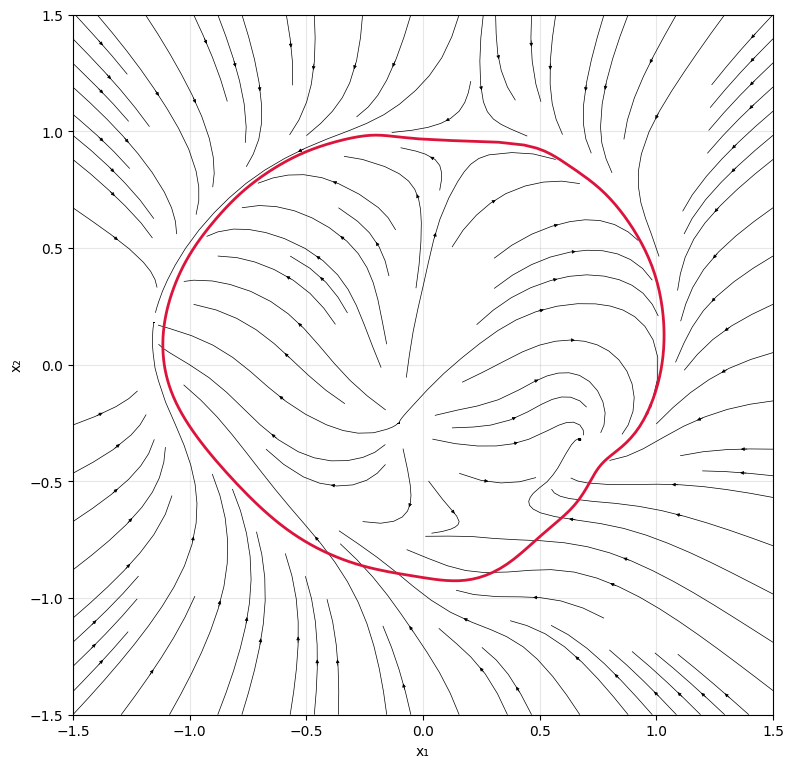

In [90]:
# Visualize the data-generating dynamics and some trajectories
fig, axes = plt.subplots(figsize=(8, 8))

# Data-generating dynamics using standard approach
plot_two_d_vector_field(data_gen_dynamics.to('cpu'), axes, min_xy=-1.5, max_xy=1.5)
# axes.set_title('Perturbed Ring Attractor\n(Data-Generating Dynamics)', fontweight='bold')

# Add sample trajectories
# for i in range(8):
#     axes.plot(z_true[i, :, 0].cpu(), z_true[i, :, 1].cpu(), 
#            'white', alpha=0.8, linewidth=2, linestyle='-')
#     axes.plot(z_true[i, :, 0].cpu(), z_true[i, :, 1].cpu(), 
#            'black', alpha=0.6, linewidth=1, linestyle='-')

axes.set_xlabel('x₁')
axes.set_ylabel('x₂')
axes.set_xlim(-1.5, 1.5)
axes.set_ylim(-1.5, 1.5)
axes.set_aspect('equal')
axes.grid(True, alpha=0.3)

# # Perfect rotational field for comparison
# ax = axes[1]

# target_rotation_field = create_rotation_vector_field(rotation_speed=0.5)
# # plot_utils.plot_two_d_vector_field(target_rotation_field, ax, min_xy=-2.5, max_xy=2.5)
# dt = 1e-2
# plot_utils.plot_two_d_vector_field(
#     lambda x: x + dt * target_rotation_field(x), ax, min_xy=-2.5, max_xy=2.5
# )
# ax.set_title('Target: Perfect Rotation\n(Regularization Goal)', fontweight='bold')

# plt.suptitle('Data Generation vs Regularization Target', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('rotation_perturbed.pdf', dpi=300, bbox_inches='tight')
plt.show()

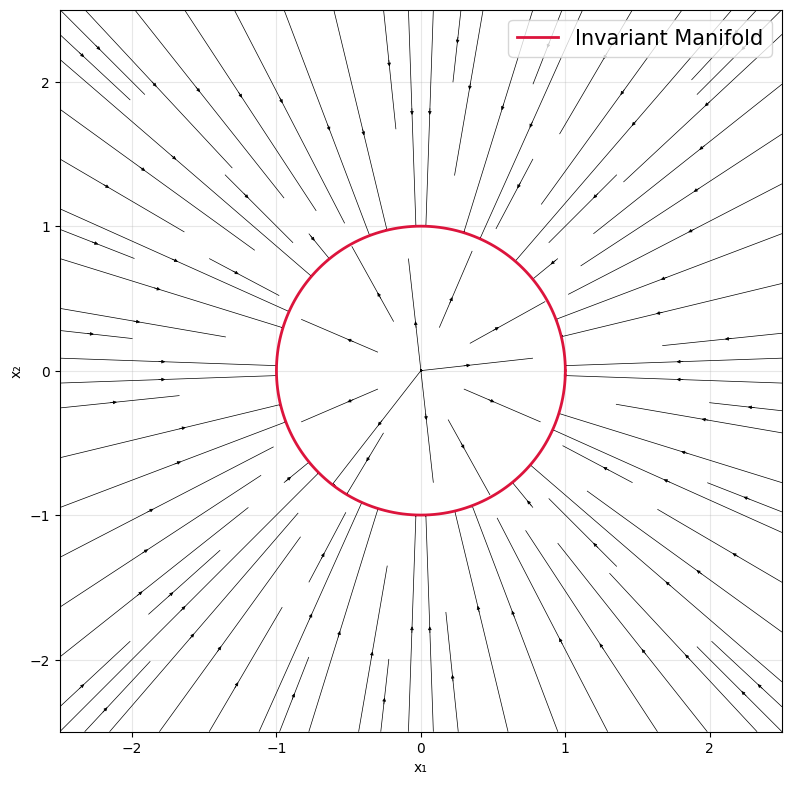

In [ ]:
fig, axes = plt.subplots(figsize=(8, 8))

# Create perfect ring attractor dynamics (unperturbed - for comparison)
perfect_ring_dynamics = PerturbedRingAttractorDynamics(
    bin_sz=1e-1, 
    lengthscale=0.3, 
    perturbation_magnitude=0.0  # No perturbations = perfect ring
).to(device)
# 2. Perfect ring attractor dynamics
plot_two_d_vector_field(perfect_ring_dynamics.to('cpu'), axes, min_xy=-2.5, max_xy=2.5)
# axes.set_title('Perfect Ring Attractor', fontweight='bold')


axes.set_xlabel('x₁')
axes.set_ylabel('x₂')
axes.set_xlim(-2.5, 2.5)
axes.set_ylim(-2.5, 2.5)
axes.set_aspect('equal')
axes.grid(True, alpha=0.3)

# plt.suptitle('Data Generation vs Regularization Target', fontsize=16, fontweight='bold')
plt.tight_layout()
# plt.savefig('rotation_invariance_setup.png', dpi=300, bbox_inches='tight')
plt.show()



## 🏗️ Enhanced SSM Factory Functions

In [7]:
def create_rotation_regularized_ssm(lambda_rotation=1.0, n_rotations=3):
    """Factory function to create RegularizedSSM with rotation invariance regularization."""
    
    # Likelihood
    H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
    readout_fn = nn.Sequential(H, C)
    likelihood_pdf = GaussianLikelihood(readout_fn, cfg.n_neurons, R_diag, device=device, fix_R=True)

    # Learnable dynamics
    dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=device)
    dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=device)

    # Initial condition
    initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=device)

    # Encoders
    backward_encoder = BackwardEncoderLRMvn(
        cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=device
    )
    local_encoder = LocalEncoderLRMvn(
        cfg.n_latents, cfg.n_neurons, cfg.n_hidden_local, cfg.n_latents,
        rank=cfg.rank_local, device=device, dropout=cfg.p_local_dropout
    )

    # Nonlinear filtering
    nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=device)

    # Create regularized SSM with rotation invariance
    regularized_ssm = RegularizedSSM(
        dynamics_mod=dynamics_mod,
        likelihood_pdf=likelihood_pdf,
        initial_c_pdf=initial_condition_pdf,
        backward_encoder=backward_encoder,
        local_encoder=local_encoder,
        nl_filter=nl_filter,
        target_vector_field=None,  # No Lie derivative regularization
        lambda_lie=0.0,
        lambda_curvature=0.0,
        lambda_rotation=lambda_rotation,  # Only rotation invariance
        n_rotations=n_rotations,
        device=device
    )
    
    return regularized_ssm


def create_comparison_ssm(lambda_lie=1.0):
    """Factory function to create RegularizedSSM with Lie derivative regularization for comparison."""
    
    # Same setup as rotation regularized SSM
    H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
    readout_fn = nn.Sequential(H, C)
    likelihood_pdf = GaussianLikelihood(readout_fn, cfg.n_neurons, R_diag, device=device, fix_R=True)

    dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=device)
    dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=device)

    initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=device)

    backward_encoder = BackwardEncoderLRMvn(
        cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=device
    )
    local_encoder = LocalEncoderLRMvn(
        cfg.n_latents, cfg.n_neurons, cfg.n_hidden_local, cfg.n_latents,
        rank=cfg.rank_local, device=device, dropout=cfg.p_local_dropout
    )

    nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=device)

    # Create regularized SSM with Lie derivative
    regularized_ssm = RegularizedSSM(
        dynamics_mod=dynamics_mod,
        likelihood_pdf=likelihood_pdf,
        initial_c_pdf=initial_condition_pdf,
        backward_encoder=backward_encoder,
        local_encoder=local_encoder,
        nl_filter=nl_filter,
        target_vector_field=target_rotation_field,  # Use rotation as target for Lie derivative
        lambda_lie=lambda_lie,
        lambda_curvature=0.0,
        lambda_rotation=0.0,  # No rotation invariance
        lie_normalize="yang",
        device=device
    )
    
    return regularized_ssm


print("🏗️ SSM factory functions created:")
print("   - create_rotation_regularized_ssm: Uses rotation invariance regularization")
print("   - create_comparison_ssm: Uses Lie derivative regularization for comparison")

🏗️ SSM factory functions created:
   - create_rotation_regularized_ssm: Uses rotation invariance regularization
   - create_comparison_ssm: Uses Lie derivative regularization for comparison


## 🚀 Enhanced Training Function with Checkpoints

In [8]:
def train_with_checkpoints(ssm, y_train, y_valid, checkpoint_manager, lambda_value=1.0, 
                          regularizer_type="rotation"):
    """Enhanced training function with checkpoint saving and detailed logging."""
    
    optimizer = torch.optim.Adam(ssm.parameters(), lr=cfg.learning_rate)
    
    # Early stopping
    best_valid_elbo = float('inf')
    patience_counter = 0
    
    # Logging
    training_log = {
        'epochs': [],
        'train_total_loss': [], 'train_elbo_loss': [], 'train_reg_loss': [],
        'valid_total_loss': [], 'valid_elbo_loss': [], 'valid_reg_loss': []
    }
    
    print(f"🚀 Training {regularizer_type} regularized SSM (λ = {lambda_value:.2e})")
    print(f"   Max epochs: {cfg.max_epochs}, Patience: {cfg.patience}")
    
    for epoch in range(1, cfg.max_epochs + 1):
        # Training phase
        ssm.train()
        train_losses = []
        
        # Shuffle training data
        indices = torch.randperm(len(y_train))
        
        for i in range(0, len(y_train), cfg.batch_sz):
            batch_indices = indices[i:i+cfg.batch_sz]
            y_batch = y_train[batch_indices]
            
            optimizer.zero_grad()
            total_loss, _, stats = ssm(y_batch, cfg.n_samples)
            total_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(ssm.parameters(), cfg.grad_clip)
            optimizer.step()
            
            train_losses.append(stats)
        
        # Average training statistics
        train_stats = {}
        for key in train_losses[0].keys():
            train_stats[key] = torch.stack([batch[key] for batch in train_losses]).mean()
        
        # Validation phase
        ssm.eval()
        with torch.no_grad():
            valid_total_loss, _, valid_stats = ssm(y_valid, cfg.n_samples)
        
        # Log training progress
        training_log['epochs'].append(epoch)
        training_log['train_total_loss'].append(train_stats['total_loss'].item())
        training_log['train_elbo_loss'].append(train_stats['elbo_loss'].item())
        training_log['valid_total_loss'].append(valid_stats['total_loss'].item())
        training_log['valid_elbo_loss'].append(valid_stats['elbo_loss'].item())
        
        if regularizer_type == "rotation":
            training_log['train_reg_loss'].append(train_stats['rotation_loss'].item())
            training_log['valid_reg_loss'].append(valid_stats['rotation_loss'].item())
        else:  # lie derivative
            training_log['train_reg_loss'].append(train_stats['lie_loss'].item())
            training_log['valid_reg_loss'].append(valid_stats['lie_loss'].item())
        
        # Prepare metrics for checkpoint saving
        metrics = {
            'total_loss': valid_stats['total_loss'].item(),
            'elbo_loss': valid_stats['elbo_loss'].item(),
        }
        
        if regularizer_type == "rotation":
            metrics['rotation_loss'] = valid_stats['rotation_loss'].item()
        else:
            metrics['lie_loss'] = valid_stats['lie_loss'].item()
        
        # Update checkpoints
        saved_checkpoints = checkpoint_manager.update_and_save(ssm, epoch, metrics)
        
        # Early stopping check
        current_valid_elbo = valid_stats['elbo_loss'].item()
        
        if current_valid_elbo < best_valid_elbo:
            best_valid_elbo = current_valid_elbo
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 5 == 0 or len(saved_checkpoints) > 0:
            reg_loss_name = 'rotation_loss' if regularizer_type == 'rotation' else 'lie_loss'
            reg_loss_val = metrics.get(reg_loss_name, 0.0)
            
            print(f"   Epoch {epoch:3d}: Train ELBO = {train_stats['elbo_loss']:.3f}, "
                  f"Valid ELBO = {current_valid_elbo:.3f}, "
                  f"{reg_loss_name.replace('_', ' ').title()} = {reg_loss_val:.3f}")
            
            if saved_checkpoints:
                print(f"   📁 Saved checkpoints: {', '.join(saved_checkpoints)}")
        
        # Early stopping
        if patience_counter >= cfg.patience:
            print(f"   🛑 Early stopping at epoch {epoch} (best valid ELBO: {best_valid_elbo:.6f})")
            break
    
    # Save final checkpoint
    final_saved = checkpoint_manager.update_and_save(ssm, epoch, metrics, force_save=True)
    print(f"   📁 Final checkpoint saved: {', '.join(final_saved)}")
    
    return {
        'final_epoch': epoch,
        'best_valid_elbo': best_valid_elbo,
        'converged': patience_counter < cfg.patience,
        'training_log': training_log,
        'checkpoint_summary': checkpoint_manager.get_summary()
    }


print("🚀 Enhanced training function with checkpoints defined")

🚀 Enhanced training function with checkpoints defined


## 🔬 Rotation Invariance Regularization Sweep

In [9]:
# Define lambda sweep for rotation invariance
# lambda_values = np.linspace(0.0, cfg.lambda_max, cfg.n_lambda_points + 1)
# lambda_values = [cfg.lambda_max]
lambda_values = [0.0, 1e-5, 1e-3, 1e-1, 1e1, 1e3]

print(f"🔬 Rotation Invariance Regularization Sweep:")
print(f"   Range: 0.0 to {cfg.lambda_max}")
print(f"   Points: {len(lambda_values)} (logarithmically spaced, plus 0)")
print(f"   Values: {[f'{x:.2e}' for x in lambda_values]}")
print(f"   Rotation samples per evaluation: {cfg.n_rotations}")

# Storage for results
rotation_results = []
rotation_models = {}
rotation_logs = {}

print(f"\n🚀 Starting rotation invariance training sweep...")
start_time = time.time()

🔬 Rotation Invariance Regularization Sweep:
   Range: 0.0 to 100.0
   Points: 6 (logarithmically spaced, plus 0)
   Values: ['0.00e+00', '1.00e-05', '1.00e-03', '1.00e-01', '1.00e+01', '1.00e+03']
   Rotation samples per evaluation: 1

🚀 Starting rotation invariance training sweep...


In [10]:
# Run rotation invariance regularization sweep
for i, lambda_rotation in enumerate(lambda_values):
    print(f"\n--- Rotation Training {i+1}/{len(lambda_values)}: λ = {lambda_rotation:.2e} ---")
    
    # Reset seed for consistent initialization
    torch.manual_seed(cfg.seed + i)
    np.random.seed(cfg.seed + i)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(cfg.seed + i)
    
    # Create fresh model
    ssm = create_rotation_regularized_ssm(lambda_rotation=lambda_rotation, n_rotations=cfg.n_rotations)

    # Test forward pass with a small batch
    test_batch = y_train[:2]  # Use 2 trials
    print(f"Testing with batch shape: {test_batch.shape}")

    with torch.no_grad():
        loss, z_samples, stats = ssm(test_batch, cfg.n_samples)

    print(f"\n✅ Forward pass successful!")
    print(f"  Total loss: {loss.item():.6f}")
    print(f"  ELBO loss: {stats['elbo_loss'].item():.6f}")
    print(f"  Lie loss: {stats['lie_loss'].item():.6f}")
    print(f"  Curvature loss: {stats['curvature_loss'].item():.6f}")
    print(f"  Total reg loss: {stats['total_reg_loss'].item():.6f}")
    print(f"  Latent samples shape: {z_samples.shape}")
    
    # Create checkpoint manager
    experiment_name = f"perturb_test_rotation_lambda_{lambda_rotation:.2e}".replace(".", "_").replace("+", "").replace("-", "neg")
    checkpoint_manager = CheckpointManager(experiment_name)
    
    # Train model
    training_result = train_with_checkpoints(
        ssm, y_train, y_valid, checkpoint_manager, 
        lambda_value=lambda_rotation, regularizer_type="rotation"
    )
    
    # Get final validation statistics
    ssm.eval()
    with torch.no_grad():
        final_total_loss, _, final_stats = ssm(y_valid, cfg.n_samples)
    
    # Store results
    result = {
        'lambda_rotation': lambda_rotation,
        'final_epoch': training_result['final_epoch'],
        'best_valid_elbo': training_result['best_valid_elbo'],
        'converged': training_result['converged'],
        'final_total_loss': final_total_loss.item(),
        'final_elbo_loss': final_stats['elbo_loss'].item(),
        'final_rotation_loss': final_stats['rotation_loss'].item(),
        'final_total_reg_loss': final_stats['total_reg_loss'].item(),
        'experiment_name': experiment_name,
        'checkpoint_summary': training_result['checkpoint_summary']
    }
    
    rotation_results.append(result)
    rotation_models[lambda_rotation] = checkpoint_manager  # Store checkpoint manager
    rotation_logs[lambda_rotation] = training_result['training_log']
    
    print(f"   Final: ELBO = {result['final_elbo_loss']:.3f}, "
          f"Rotation = {result['final_rotation_loss']:.3f}, "
          f"Total = {result['final_total_loss']:.3f}")
    
    # Print checkpoint summary
    summary = training_result['checkpoint_summary']
    print(f"   📊 Checkpoints: ELBO (epoch {summary['elbo_loss']['best_epoch']}, {summary['elbo_loss']['best_value']:.3f}), "
          f"Total (epoch {summary['total_loss']['best_epoch']}, {summary['total_loss']['best_value']:.3f})")

elapsed_time = time.time() - start_time
print(f"\n✅ Rotation invariance sweep completed in {elapsed_time/60:.1f} minutes")
print(f"   Trained {len(rotation_results)} models successfully")
print(f"   📁 All checkpoints saved with best models for each λ value")


--- Rotation Training 1/6: λ = 0.00e+00 ---
Testing with batch shape: torch.Size([2, 75, 100])

✅ Forward pass successful!
  Total loss: 15454.208008
  ELBO loss: 15454.208008
  Lie loss: 0.000000
  Curvature loss: 0.000000
  Total reg loss: 0.000000
  Latent samples shape: torch.Size([5, 2, 75, 2])
💾 CheckpointManager initialized
   Save directory: ckpts_rotation_invariance
   Experiment: perturb_test_rotation_lambda_0_00e00
🚀 Training rotation regularized SSM (λ = 0.00e+00)
   Max epochs: 25, Patience: 5
   Epoch   1: Train ELBO = 19987.217, Valid ELBO = 19325.998, Rotation Loss = 0.000
   📁 Saved checkpoints: total_loss, elbo_loss, rotation_loss
   Epoch   2: Train ELBO = 19253.816, Valid ELBO = 18674.131, Rotation Loss = 0.000
   📁 Saved checkpoints: total_loss, elbo_loss
   Epoch   3: Train ELBO = 18044.045, Valid ELBO = 16129.880, Rotation Loss = 0.000
   📁 Saved checkpoints: total_loss, elbo_loss
   Epoch   4: Train ELBO = 13560.385, Valid ELBO = 11225.862, Rotation Loss = 0.00

## 📊 Results Analysis and Comparison

In [11]:
# Convert results to DataFrame for analysis
df_rotation = pd.DataFrame(rotation_results)

print(f"📊 Rotation Invariance Results Summary:")
print(f"   Converged models: {df_rotation['converged'].sum()}/{len(df_rotation)}")
print(f"   Average final epoch: {df_rotation['final_epoch'].mean():.1f}")
print(f"   ELBO loss range: {df_rotation['final_elbo_loss'].min():.3f} - {df_rotation['final_elbo_loss'].max():.3f}")
print(f"   Rotation loss range: {df_rotation['final_rotation_loss'].min():.3e} - {df_rotation['final_rotation_loss'].max():.3e}")

# Save results
df_rotation.to_csv('rotation_invariance_sweep_results.csv', index=False)
print(f"💾 Results saved to rotation_invariance_sweep_results.csv")

# Find optimal regularization values
min_total_idx = df_rotation['final_total_loss'].idxmin()
min_elbo_idx = df_rotation['final_elbo_loss'].idxmin()

print(f"\n🎯 Optimal Regularization Values:")
print(f"   Best Total Loss: λ = {df_rotation.loc[min_total_idx, 'lambda_rotation']:.2e} "
      f"(Total = {df_rotation.loc[min_total_idx, 'final_total_loss']:.3f})")
print(f"   Best ELBO Loss: λ = {df_rotation.loc[min_elbo_idx, 'lambda_rotation']:.2e} "
      f"(ELBO = {df_rotation.loc[min_elbo_idx, 'final_elbo_loss']:.3f})")

optimal_lambda = df_rotation.loc[min_total_idx, 'lambda_rotation']
print(f"\n🏆 RECOMMENDED: λ_rotation = {optimal_lambda:.2e} (best total loss)")

📊 Rotation Invariance Results Summary:
   Converged models: 6/6
   Average final epoch: 25.0
   ELBO loss range: 2304.957 - 2424.283
   Rotation loss range: 0.000e+00 - 3.062e+01
💾 Results saved to rotation_invariance_sweep_results.csv

🎯 Optimal Regularization Values:
   Best Total Loss: λ = 0.00e+00 (Total = 2304.957)
   Best ELBO Loss: λ = 0.00e+00 (ELBO = 2304.957)

🏆 RECOMMENDED: λ_rotation = 0.00e+00 (best total loss)


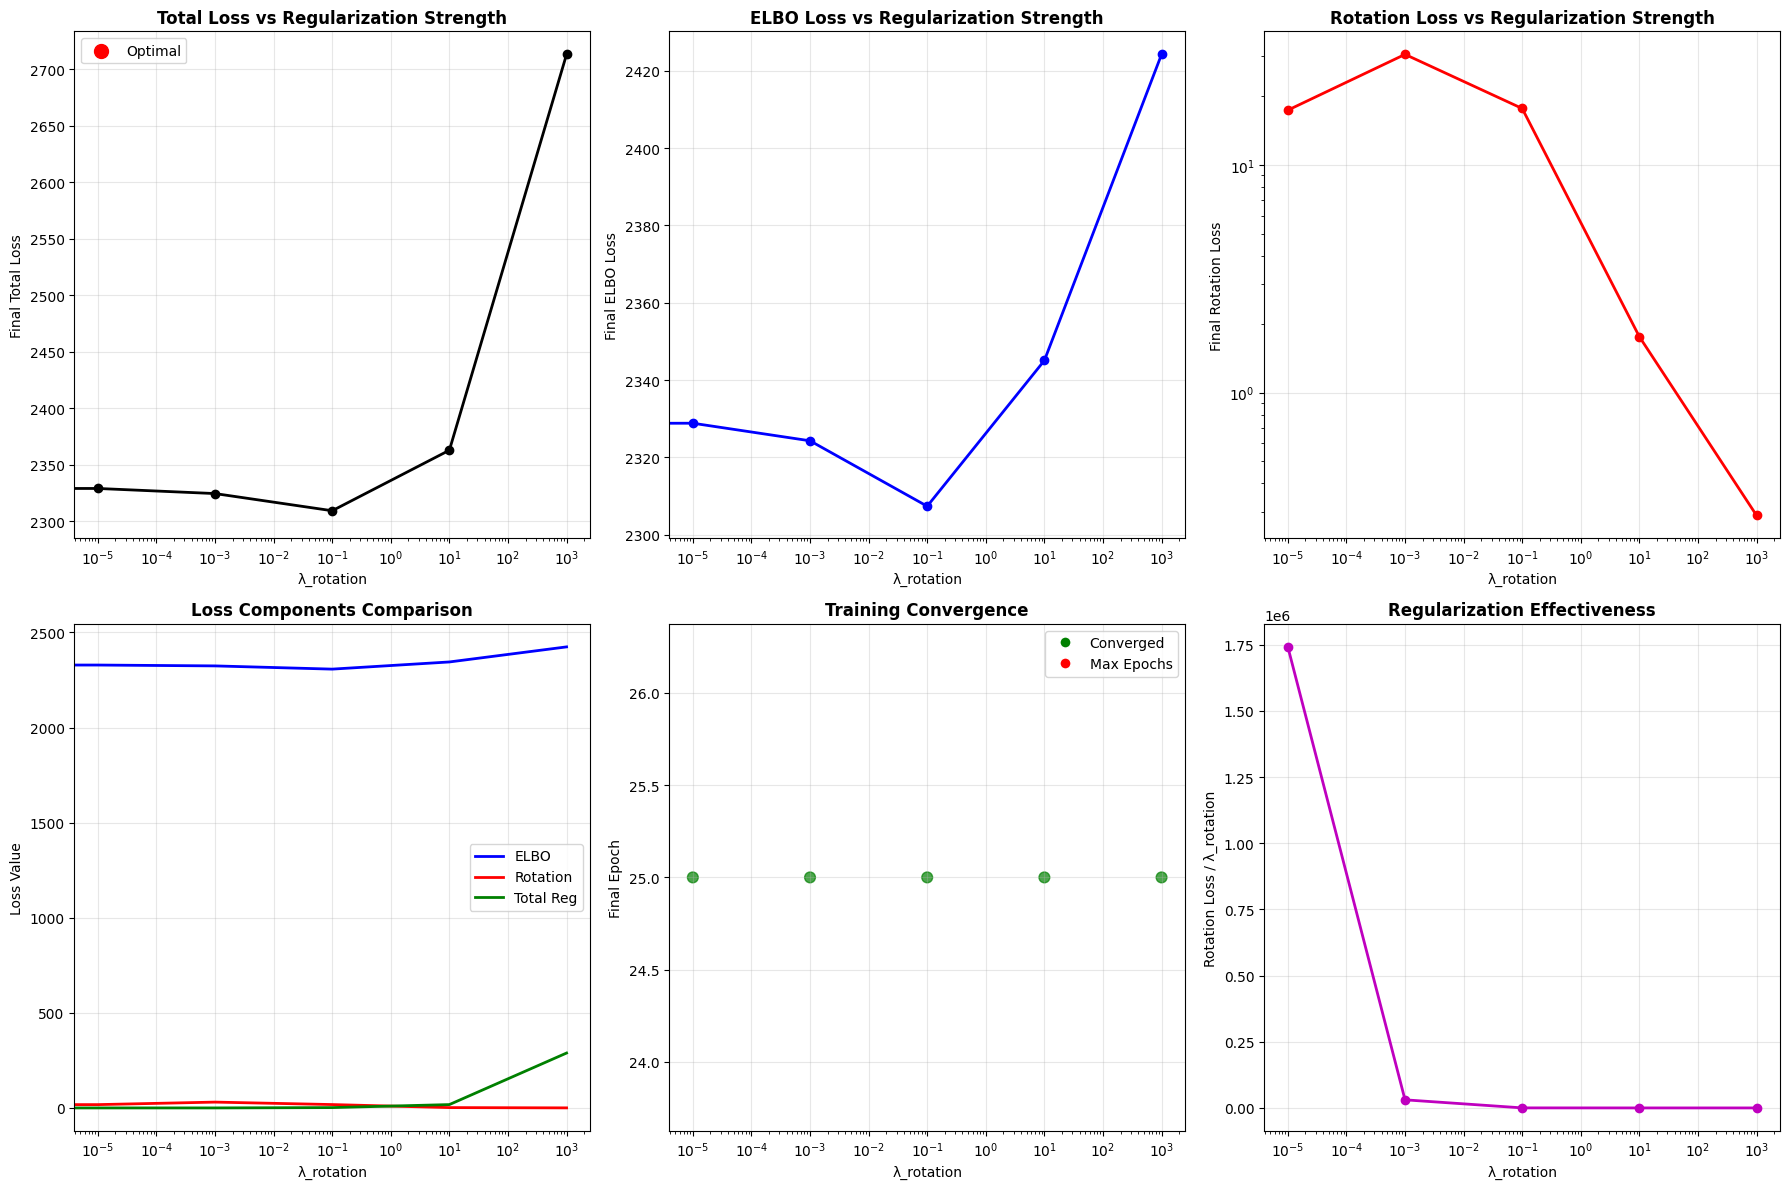

📊 Comprehensive rotation invariance analysis saved as 'rotation_invariance_analysis.png'


In [12]:
# Comprehensive analysis plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Total Loss vs Lambda
ax = axes[0, 0]
ax.semilogx(df_rotation['lambda_rotation'], df_rotation['final_total_loss'], 'ko-', linewidth=2, markersize=6)
ax.set_xlabel('λ_rotation')
ax.set_ylabel('Final Total Loss')
ax.set_title('Total Loss vs Regularization Strength', fontweight='bold')
ax.grid(True, alpha=0.3)
# Highlight optimal
opt_idx = min_total_idx
ax.scatter(df_rotation.loc[opt_idx, 'lambda_rotation'], df_rotation.loc[opt_idx, 'final_total_loss'], 
          color='red', s=100, zorder=5, label='Optimal')
ax.legend()

# 2. ELBO Loss vs Lambda
ax = axes[0, 1]
ax.semilogx(df_rotation['lambda_rotation'], df_rotation['final_elbo_loss'], 'bo-', linewidth=2, markersize=6)
ax.set_xlabel('λ_rotation')
ax.set_ylabel('Final ELBO Loss')
ax.set_title('ELBO Loss vs Regularization Strength', fontweight='bold')
ax.grid(True, alpha=0.3)

# 3. Rotation Loss vs Lambda
ax = axes[0, 2]
mask = df_rotation['final_rotation_loss'] > 0
if mask.any():
    ax.loglog(df_rotation.loc[mask, 'lambda_rotation'], df_rotation.loc[mask, 'final_rotation_loss'], 
              'ro-', linewidth=2, markersize=6)
ax.set_xlabel('λ_rotation')
ax.set_ylabel('Final Rotation Loss')
ax.set_title('Rotation Loss vs Regularization Strength', fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Loss Components Comparison
ax = axes[1, 0]
ax.set_xscale('log')
ax.plot(df_rotation['lambda_rotation'], df_rotation['final_elbo_loss'], 'b-', label='ELBO', linewidth=2)
ax.plot(df_rotation['lambda_rotation'], df_rotation['final_rotation_loss'], 'r-', label='Rotation', linewidth=2)
ax.plot(df_rotation['lambda_rotation'], df_rotation['final_total_reg_loss'], 'g-', label='Total Reg', linewidth=2)
ax.set_xlabel('λ_rotation')
ax.set_ylabel('Loss Value')
ax.set_title('Loss Components Comparison', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Training Convergence
ax = axes[1, 1]
colors = ['green' if converged else 'red' for converged in df_rotation['converged']]
scatter = ax.scatter(df_rotation['lambda_rotation'], df_rotation['final_epoch'], 
                    c=colors, alpha=0.7, s=60)
ax.set_xscale('log')
ax.set_xlabel('λ_rotation')
ax.set_ylabel('Final Epoch')
ax.set_title('Training Convergence', fontweight='bold')
ax.grid(True, alpha=0.3)

# Add legend for convergence
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                         markersize=8, label='Converged'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Max Epochs')]
ax.legend(handles=legend_elements)

# 6. Regularization Effectiveness
ax = axes[1, 2]
# Plot rotation loss normalized by lambda (shows regularizer effectiveness)
mask = (df_rotation['lambda_rotation'] > 0) & (df_rotation['final_rotation_loss'] > 0)
if mask.any():
    effectiveness = df_rotation.loc[mask, 'final_rotation_loss'] / df_rotation.loc[mask, 'lambda_rotation']
    ax.semilogx(df_rotation.loc[mask, 'lambda_rotation'], effectiveness, 'mo-', linewidth=2, markersize=6)
ax.set_xlabel('λ_rotation')
ax.set_ylabel('Rotation Loss / λ_rotation')
ax.set_title('Regularization Effectiveness', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('rotation_invariance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Comprehensive rotation invariance analysis saved as 'rotation_invariance_analysis.png'")

## 🎨 Vector Field Visualization with Speed Overlays

🎨 Visualizing learned vector fields for 6 regularization strengths:
   1. λ = 0.00e+00
   2. λ = 1.00e-05
   3. λ = 1.00e-03
   4. λ = 1.00e-01
   5. λ = 1.00e+01
   6. λ = 1.00e+03
📥 Loaded best elbo_loss checkpoint from epoch 25
   Value: 2304.869629
   Path: ckpts_rotation_invariance/perturb_test_rotation_lambda_0_00e00_best_elbo_loss_epoch_025.pt
📥 Loaded best elbo_loss checkpoint from epoch 25
   Value: 2318.485352
   Path: ckpts_rotation_invariance/perturb_test_rotation_lambda_1_00eneg05_best_elbo_loss_epoch_025.pt
📥 Loaded best elbo_loss checkpoint from epoch 24
   Value: 2322.132568
   Path: ckpts_rotation_invariance/perturb_test_rotation_lambda_1_00eneg03_best_elbo_loss_epoch_024.pt
📥 Loaded best elbo_loss checkpoint from epoch 25
   Value: 2306.436523
   Path: ckpts_rotation_invariance/perturb_test_rotation_lambda_1_00eneg01_best_elbo_loss_epoch_025.pt
📥 Loaded best elbo_loss checkpoint from epoch 25
   Value: 2341.173096
   Path: ckpts_rotation_invariance/perturb_test_rotati

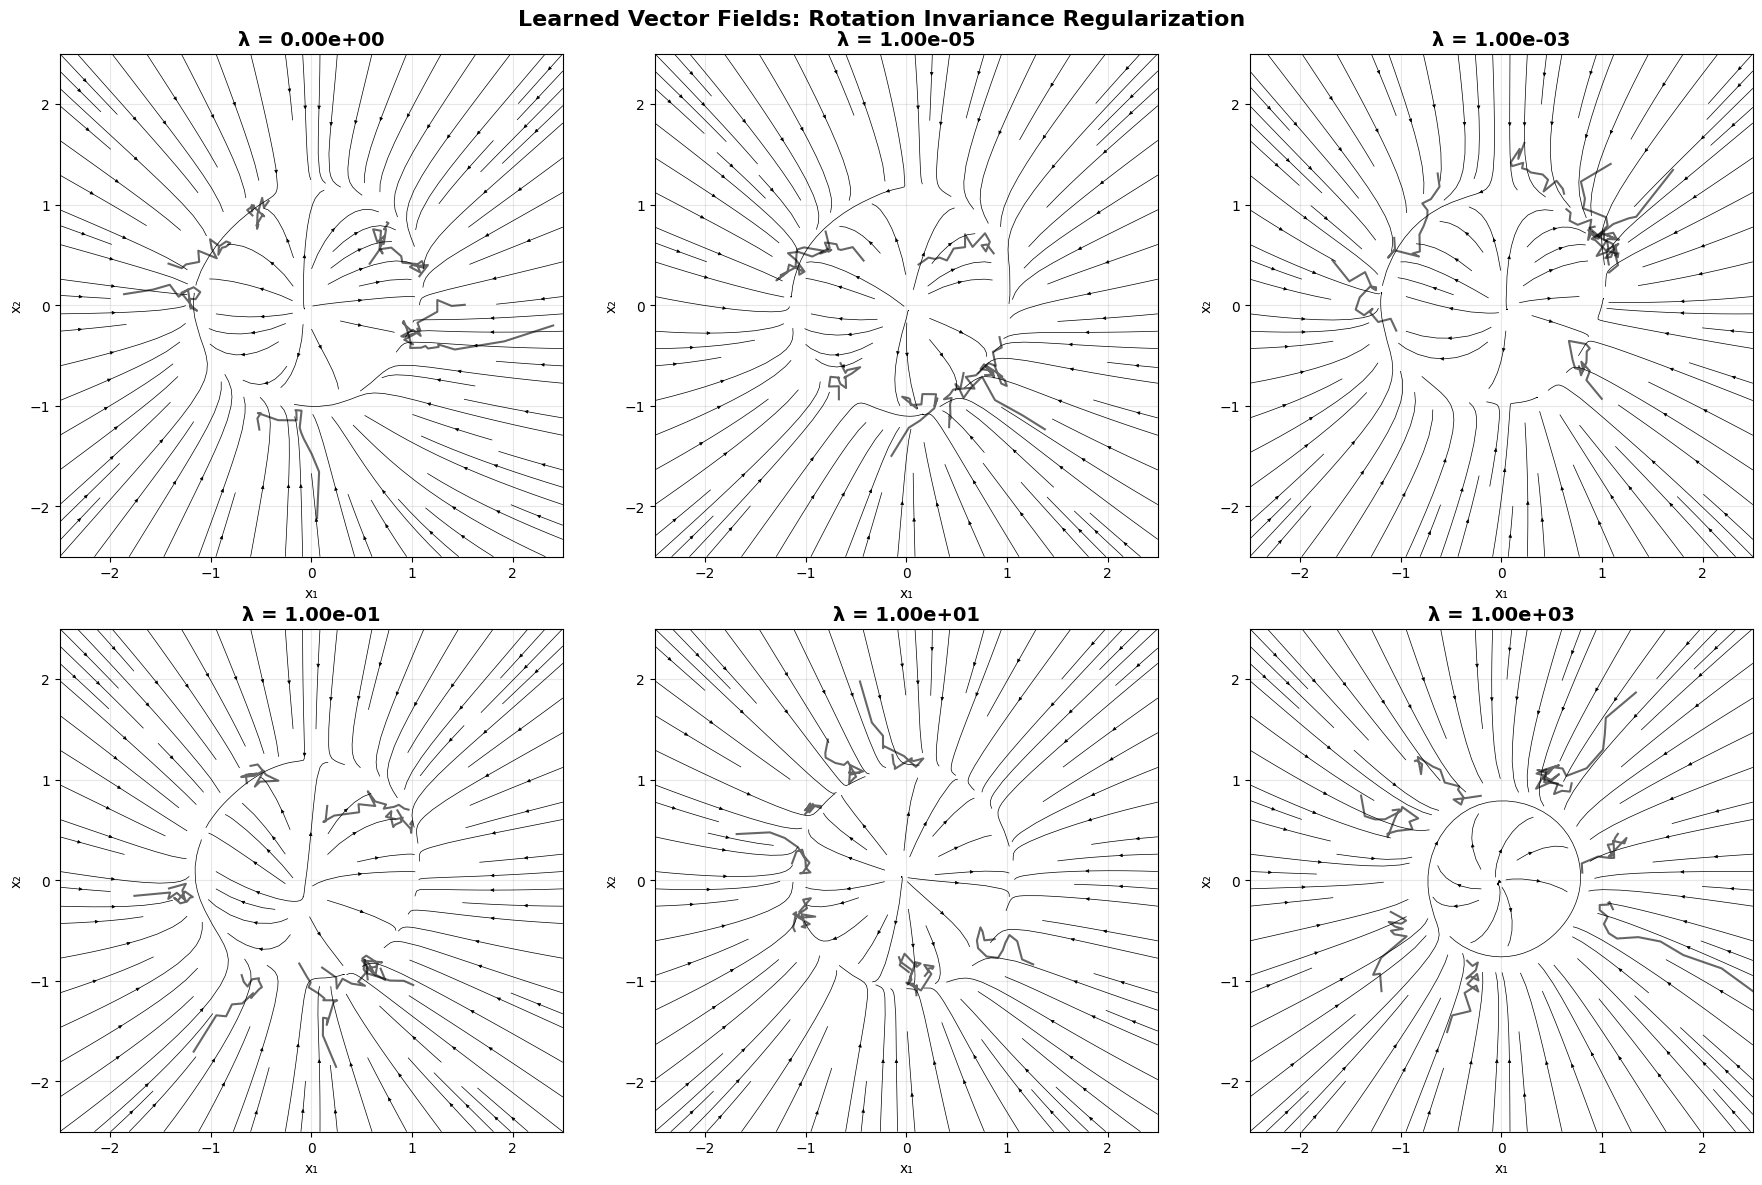

🎨 Vector field evolution saved as 'rotation_vector_fields.png'


In [95]:
# Select interesting lambda values for visualization
n_plots = 6
interesting_indices = np.linspace(0, len(lambda_values)-1, n_plots, dtype=int)
interesting_lambdas = [lambda_values[i] for i in interesting_indices]

print(f"🎨 Visualizing learned vector fields for {n_plots} regularization strengths:")
for i, lambda_val in enumerate(interesting_lambdas):
    print(f"   {i+1}. λ = {lambda_val:.2e}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, lambda_val in enumerate(interesting_lambdas):
    ax = axes[i]
    
    # Load the best model for this lambda
    checkpoint_manager = rotation_models[lambda_val]
    ssm = create_rotation_regularized_ssm(lambda_rotation=lambda_val, n_rotations=cfg.n_rotations)
    
    try:
        # Try to load best total loss checkpoint
        # checkpoint_manager.load_best_checkpoint(ssm, 'total_loss')
        checkpoint_manager.load_best_checkpoint(ssm, 'elbo_loss')
    except (FileNotFoundError, ValueError):
        # Fallback to best ELBO checkpoint
        try:
            checkpoint_manager.load_best_checkpoint(ssm, 'elbo_loss')
        except (FileNotFoundError, ValueError):
            print(f"   Warning: No checkpoint found for λ = {lambda_val:.2e}, using final model")
    
    ssm.eval()
    
    # Plot learned vector field using standard approach
    plot_utils.plot_two_d_vector_field(
        ssm.dynamics_mod.mean_fn, ax, min_xy=-2.5, max_xy=2.5
    )
    
    ax.set_title(f'λ = {lambda_val:.2e}', fontweight='bold', fontsize=14)
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Add some sample trajectories
    with torch.no_grad():        # Generate short trajectories from random initial conditions
        n_traj = 8
        z_0 = torch.zeros((1, n_traj, 2))
        z_0[0] = 1.5 * torch.randn(n_traj, 2)  # Random initial conditions
        z_pred = ssm.predict_forward(z_0, 15).detach()
        
        for j in range(n_traj):
            ax.plot(z_pred[0, j, :, 0], z_pred[0, j, :, 1], 
                   'k-', alpha=0.6, linewidth=1.5)

plt.suptitle('Learned Vector Fields: Rotation Invariance Regularization', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
# plt.savefig('rotation_vector_fields.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"🎨 Vector field evolution saved as 'rotation_vector_fields.png'")

In [ ]:
def plot_two_d_vector_field(
    dynamics_fn, axs, min_xy=-3, max_xy=3, n_pts=100, device="cpu", plot_invmanifold=True, invman_n_points=1
):
    with torch.no_grad():
        x = np.linspace(min_xy, max_xy, n_pts)
        y = np.linspace(min_xy, max_xy, n_pts)
        X, Y = np.meshgrid(x, y)

        XY = torch.zeros((X.shape[0] ** 2, 2), device=device)
        XY[:, 0] = torch.from_numpy(X).flatten()
        XY[:, 1] = torch.from_numpy(Y).flatten()
        XY_out = dynamics_fn(XY.to(device))
        s = XY_out - XY
        u = s[:, 0].reshape(X.shape[0], X.shape[1])
        v = s[:, 1].reshape(Y.shape[0], Y.shape[1])
        (X, Y, u, v) = [
            t.to("cpu") if isinstance(t, torch.Tensor) else t for t in (X, Y, u, v)
        ]

        axs.streamplot(X, Y, u, v, color="black", linewidth=0.5, arrowsize=0.5)

        # Use a ring of initial conditions
        theta = np.linspace(0, 2 * np.pi, invman_n_points, endpoint=False)
        init_cond = np.stack([np.cos(theta), np.sin(theta)], axis=1)
        # Simulate the dynamics for each initial condition
        # We'll use a simple Euler integration for a fixed number of steps
        z = torch.tensor(init_cond, dtype=torch.float32, device=device)
        n_steps = 1000000
        dt = 0.01
        z_stack = []
        for _ in range(n_steps):
            dz = dynamics_fn(z) - z
            z = z + dt * dz
            z_stack.append(z)
        z_stack = [z.detach().cpu().numpy() for z in z_stack]
        z_stack = np.array(z_stack).reshape((1000000,2))
        z_stack = z_stack[100000:]
        print(z_stack.shape)
        axs.plot(z_stack[:, 0], z_stack[:, 1], color="crimson", lw=2, label="Invariant Manifold")
        # axs.legend(loc="upper right", fontsize=15, frameon=True)


🎨 Visualizing learned vector fields for baseline and largest regularization strengths (separate plots):
   1. Baseline: λ = 0.00e+00
   2. Largest λ: λ = 1.00e+03
📥 Loaded best elbo_loss checkpoint from epoch 25
   Value: 2304.869629
   Path: ckpts_rotation_invariance/perturb_test_rotation_lambda_0_00e00_best_elbo_loss_epoch_025.pt
(900000, 2)
$λ_{rot}$


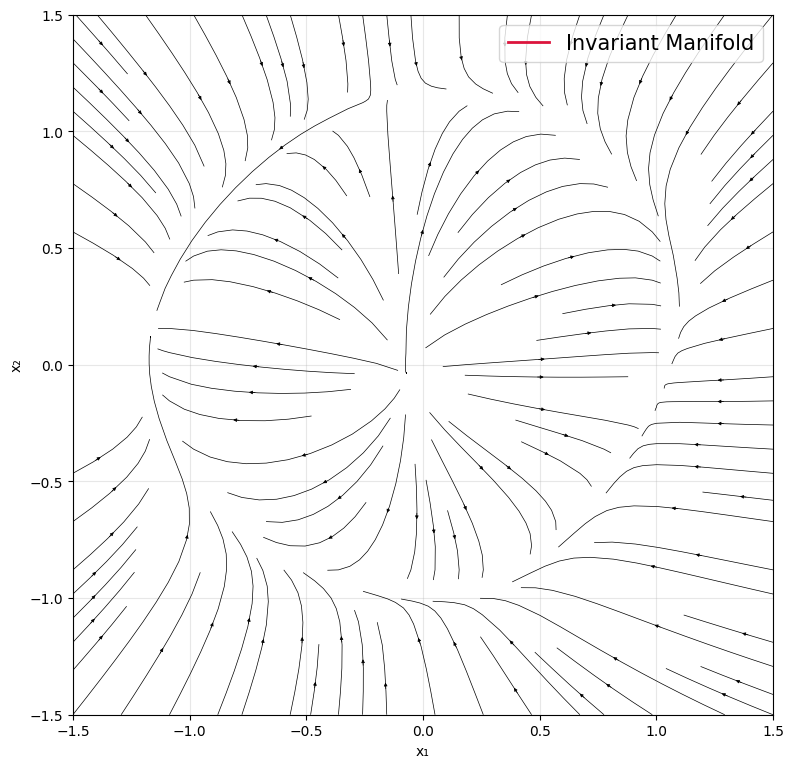

📥 Loaded best elbo_loss checkpoint from epoch 25
   Value: 2422.755371
   Path: ckpts_rotation_invariance/perturb_test_rotation_lambda_1_00e03_best_elbo_loss_epoch_025.pt
(900000, 2)
$λ_{rot}$


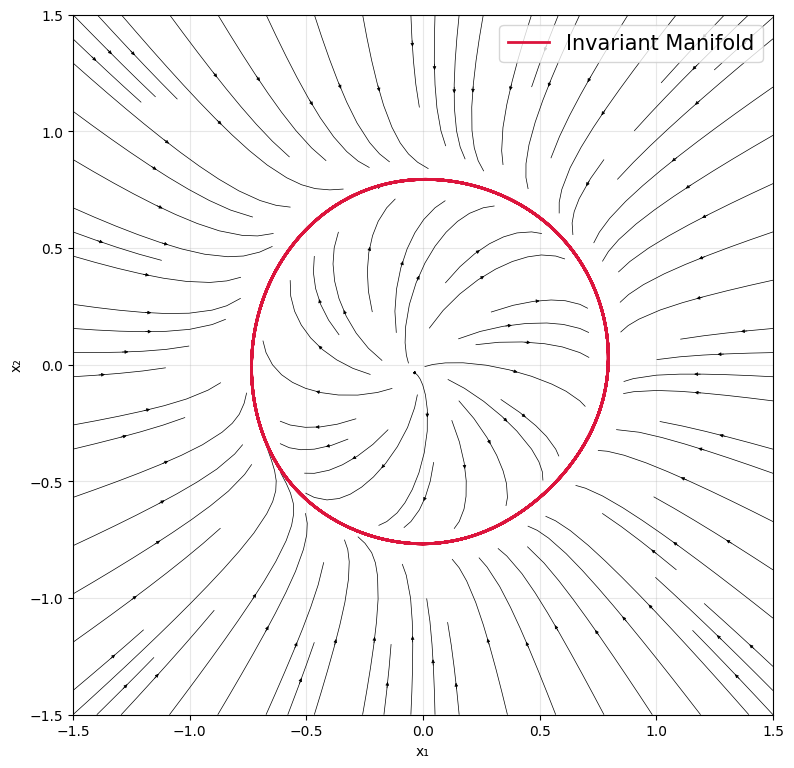

In [94]:
# Only plot the baseline (lambda=0) and the largest lambda value

# Select baseline and largest lambda for visualization
baseline_lambda = lambda_values[0]
largest_lambda = lambda_values[-1]
interesting_lambdas = [baseline_lambda, largest_lambda]

print(f"🎨 Visualizing learned vector fields for baseline and largest regularization strengths (separate plots):")
for i, lambda_val in enumerate(interesting_lambdas):
    label = "Baseline" if i == 0 else "Largest λ"
    print(f"   {i+1}. {label}: λ = {lambda_val:.2e}")

for i, lambda_val in enumerate(interesting_lambdas):
    label = "Baseline" if i == 0 else "Largest λ"
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Load the best model for this lambda
    checkpoint_manager = rotation_models[lambda_val]
    ssm = create_rotation_regularized_ssm(lambda_rotation=lambda_val, n_rotations=cfg.n_rotations)
    checkpoint_manager.load_best_checkpoint(ssm, 'elbo_loss')
    
    ssm.eval()
    
    # Plot learned vector field using standard approach
    plot_two_d_vector_field(
        ssm.dynamics_mod.mean_fn, ax, min_xy=-1.5, max_xy=1.5, 
    )
    
    lambda_string = r'$λ_{rot}$'
    print(lambda_string)
    # ax.set_title(f"Inferred Vector Field: {lambda_string} = {lambda_val}", fontweight='bold', fontsize=14)
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'rotation_vector_field_{label.replace(" ", "_").lower()}.pdf', dpi=300, bbox_inches="tight")
    plt.show()

## 🔍 Regularization Spatial Analysis

[0.0, 1e-05, 0.001, 0.1, 10.0, 1000.0]
🔍 Enhanced spatial analysis with radial norm calculation:
   Analyzing λ = 1.00e+03
📥 Loaded best elbo_loss checkpoint from epoch 25
   Value: 2422.755371
   Path: ckpts_rotation_invariance/perturb_test_rotation_lambda_1_00e03_best_elbo_loss_epoch_025.pt

📊 Radial Norm Analysis Summary:
   λ = 1.00e+03: Center norm = 0.0016, Edge norm = 1.7548, Ratio = 1104.80


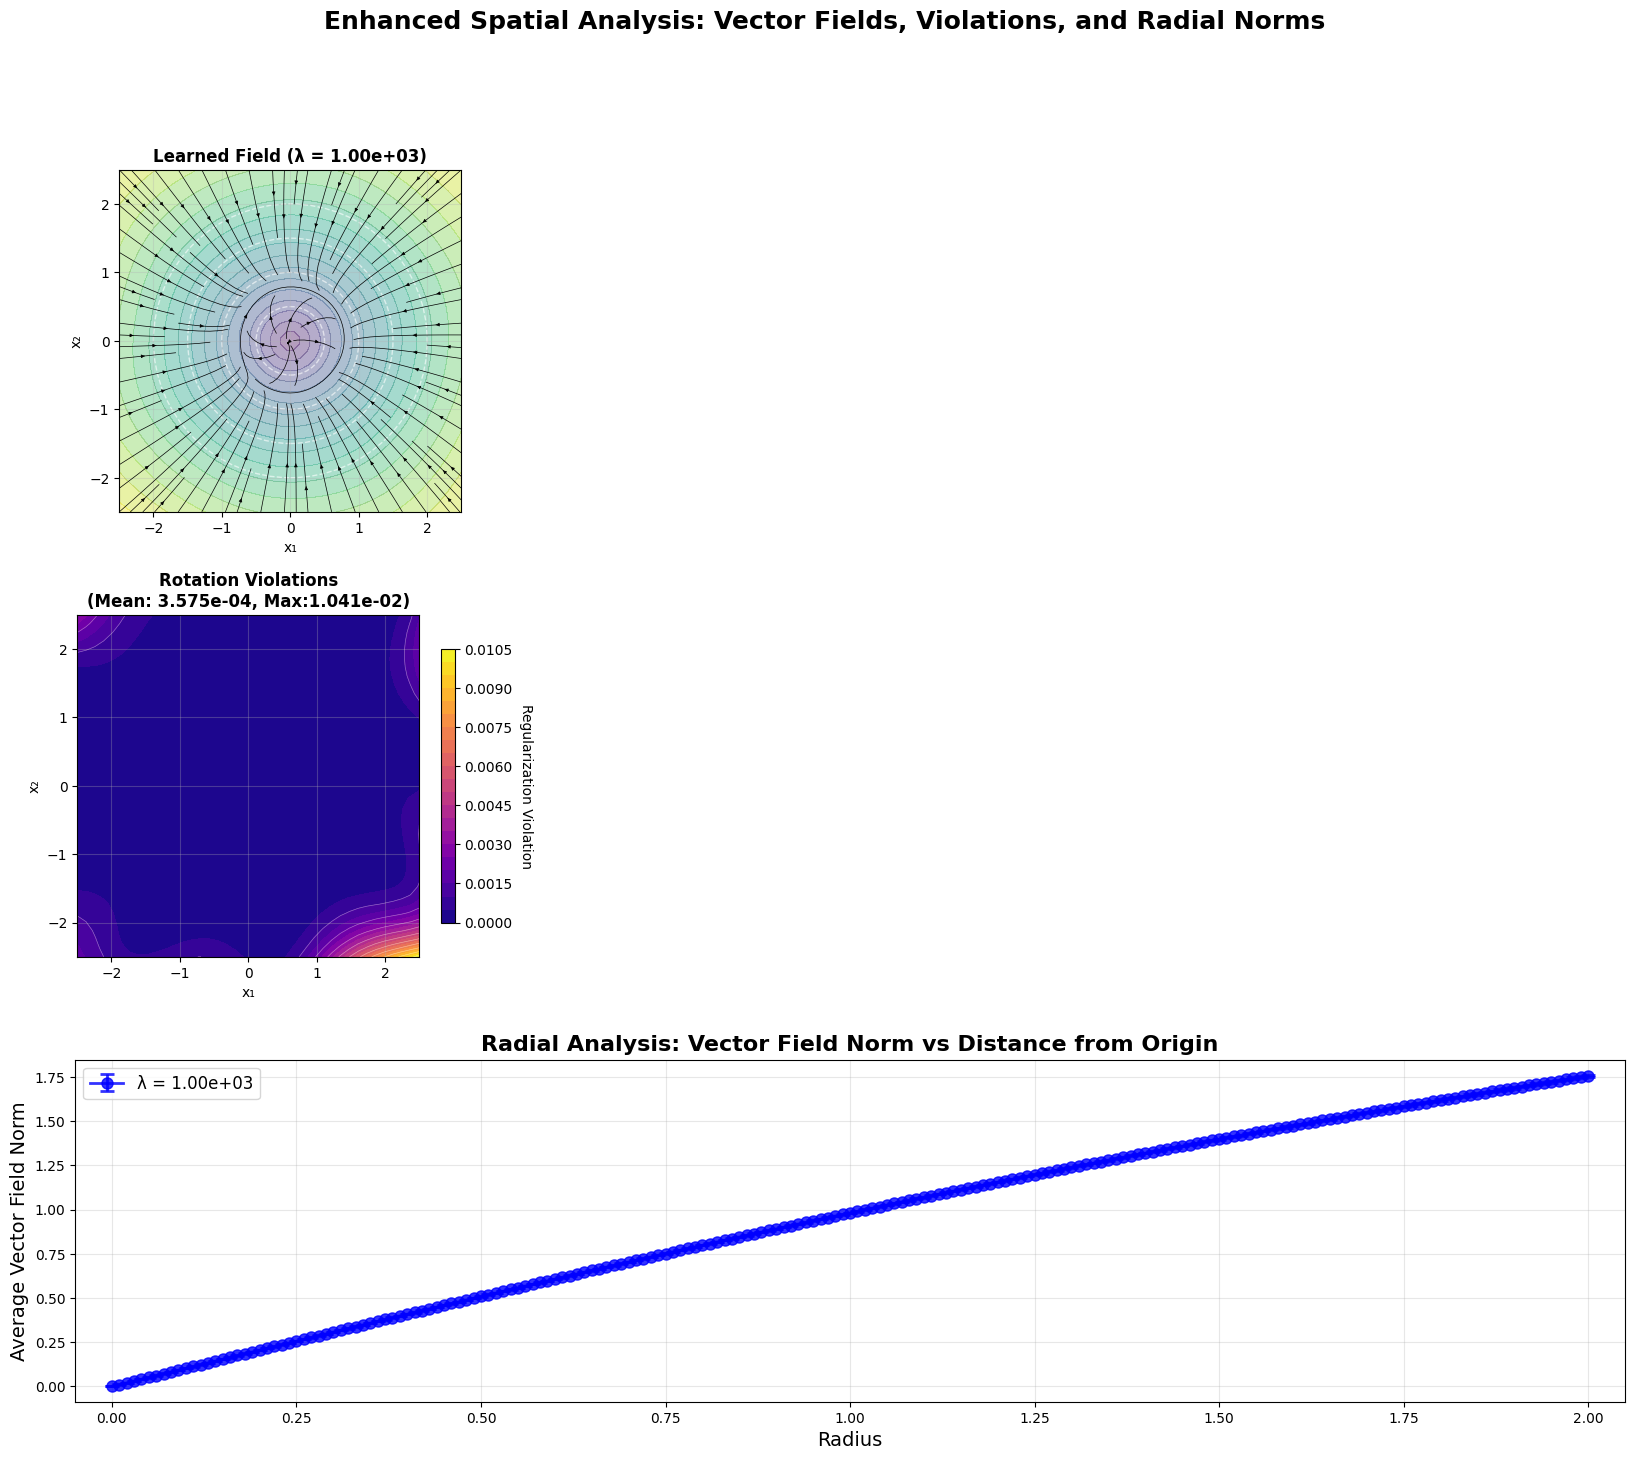

🔍 Enhanced spatial analysis saved as 'enhanced_rotation_spatial_analysis.png'


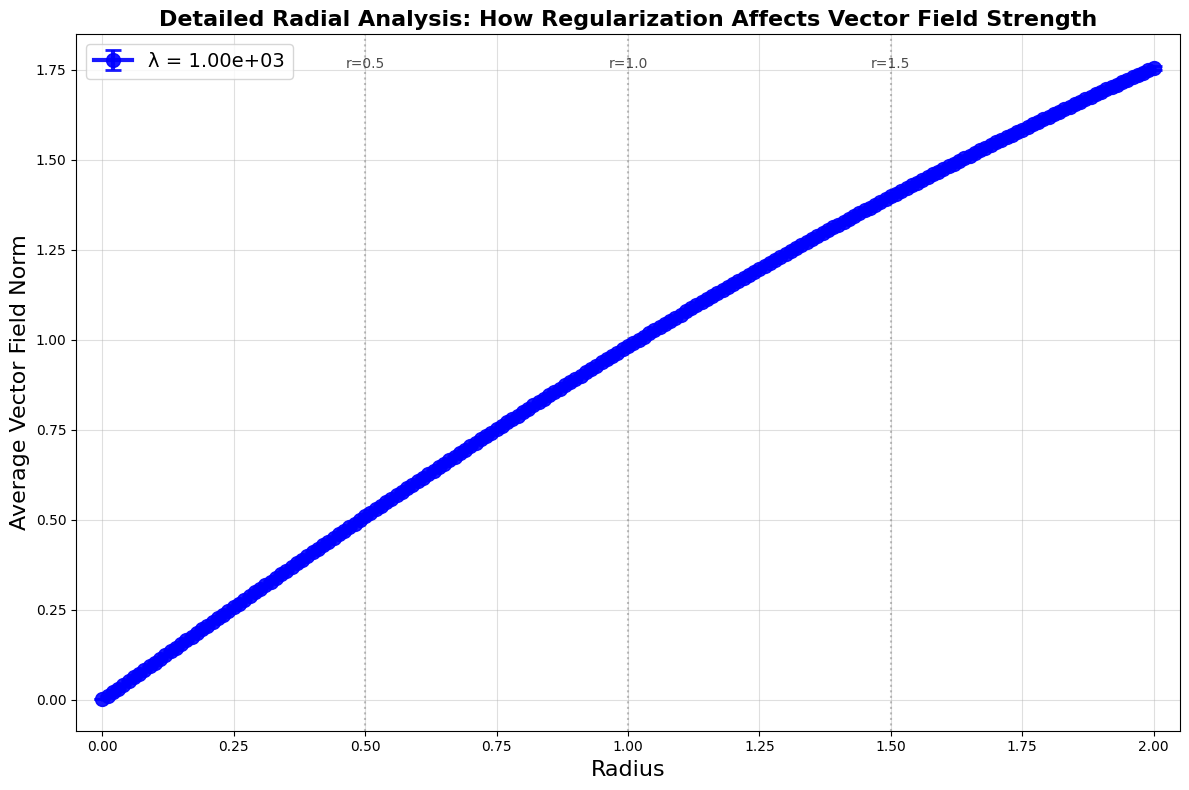

📈 Detailed radial analysis saved as 'detailed_radial_analysis.png'


In [14]:
# Enhanced spatial analysis with radial norm analysis
analysis_lambdas = [lambda_values[-1]]  # No reg, optimal, high reg

print(lambda_values)

print(f"🔍 Enhanced spatial analysis with radial norm calculation:")
for lambda_val in analysis_lambdas:
    print(f"   Analyzing λ = {lambda_val:.2e}")

def calculate_radial_norms(vector_field_fn, radii, n_samples=100):
    """
    Calculate average vector field norms at different radii.
    
    Args:
        vector_field_fn: Vector field function
        radii: List of radii to analyze
        n_samples: Number of points to sample around each circle
        
    Returns:
        radii_values, mean_norms, std_norms
    """
    radii_values = []
    mean_norms = []
    std_norms = []

    for r in radii:
        if r == 0:
            # Special case for center point
            center_point = torch.zeros(1, 2)
            with torch.no_grad():
                center_vector = vector_field_fn(center_point)
                center_norm = torch.linalg.norm(center_vector, dim=-1).item()

            radii_values.append(r)
            mean_norms.append(center_norm)
            std_norms.append(0.0)
        else:
            # Sample points around circle of radius r
            angles = np.linspace(0, 2*np.pi, n_samples, endpoint=False)
            circle_points = torch.tensor([
                [r * np.cos(angle), r * np.sin(angle)] for angle in angles
            ], dtype=torch.float32)

            with torch.no_grad():
                vectors = vector_field_fn(circle_points)
                norms = torch.linalg.norm(vectors, dim=-1)

            radii_values.append(r)
            mean_norms.append(norms.mean().item())
            std_norms.append(norms.std().item())

    return radii_values, mean_norms, std_norms

# Define radii to analyze
radii = np.arange(0.0, 2.01, 0.01).tolist()

# Create figure with vector fields, violations, and radial analysis
fig = plt.figure(figsize=(20, 16))

# Create subplot layout: 3x4 grid
# Top row: vector fields (3 plots)
# Second row: violations (3 plots) 
# Bottom row: radial norm analysis (1 large plot spanning 3 columns)
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1], hspace=0.3, wspace=0.3)

# Store radial data for all models
all_radial_data = {}

for i, lambda_val in enumerate(analysis_lambdas):
    # Load model
    checkpoint_manager = rotation_models[lambda_val]
    ssm = create_rotation_regularized_ssm(lambda_rotation=lambda_val, n_rotations=cfg.n_rotations)

    try:
        checkpoint_manager.load_best_checkpoint(ssm, 'elbo_loss')
    except (FileNotFoundError, ValueError):
        try:
            checkpoint_manager.load_best_checkpoint(ssm, 'elbo_loss')
        except (FileNotFoundError, ValueError):
            pass

    ssm.eval()

    # Calculate radial norms
    radii_vals, mean_norms, std_norms = calculate_radial_norms(ssm.dynamics_mod.mean_fn, radii)
    all_radial_data[lambda_val] = {
        'radii': radii_vals,
        'mean_norms': mean_norms,
        'std_norms': std_norms
    }

    # Plot learned vector field (top row)
    ax = fig.add_subplot(gs[0, i])
    plot_vector_field_with_speed_overlay(ssm.dynamics_mod.mean_fn, ax, min_xy=-2.5, max_xy=2.5, grid_size=50, 
                                        colormap='viridis', speed_alpha=0.4, title=None)
    # plot_utils.plot_two_d_vector_field(
    #     ssm.dynamics_mod.mean_fn, ax, min_xy=-2.5, max_xy=2.5
    # )
    ax.set_title(f'Learned Field (λ = {lambda_val:.2e})', fontweight='bold')
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    # Add circles to show radii being analyzed
    for r in [0.5, 1.0, 1.5, 2.0]:
        circle = plt.Circle((0, 0), r, fill=False, color='white', alpha=0.6, linewidth=1, linestyle='--')
        ax.add_patch(circle)

    # Plot rotation invariance violations (middle row)
    ax = fig.add_subplot(gs[1, i])
    if lambda_val > 0:
        # Create rotation regularizer for spatial analysis
        rotation_regularizer = RotationInvarianceRegularizer(
            ssm.dynamics_mod.mean_fn, n_rotations=cfg.n_rotations
        )

        # First get the violations data, then create the plot with proper title
        im, violations = plot_regularization_heatmap(
            rotation_regularizer, ax, min_xy=-2.5, max_xy=2.5,
            grid_size=40, colormap='plasma'
        )

        # Now update the title with the calculated statistics
        ax.set_title(f'Rotation Violations\n(Mean: {violations.mean():.3e}, Max:{violations.max():.3e})',fontweight='bold')
    else:
        # For λ=0, show uniform "violation" (no regularization)
        ax.text(0.5, 0.5, 'No Rotation\nRegularization',
                ha='center', va='center', transform=ax.transAxes,
                fontsize=14, fontweight='bold')
        ax.set_title('No Regularization', fontweight='bold')
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)

    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')

# Plot radial norm analysis (bottom row, spanning all columns)
ax_radial = fig.add_subplot(gs[2, :])

colors = ['blue', 'red', 'green']
markers = ['o', 's', '^']
labels = [f'λ = {lam:.2e}' for lam in analysis_lambdas]

for i, lambda_val in enumerate(analysis_lambdas):
    data = all_radial_data[lambda_val]

    # Plot mean with error bars
    ax_radial.errorbar(data['radii'], data['mean_norms'], yerr=data['std_norms'],
                    color=colors[i], marker=markers[i], markersize=8,
linewidth=2,
                    capsize=5, capthick=2, label=labels[i], alpha=0.8)

ax_radial.set_xlabel('Radius', fontsize=14)
ax_radial.set_ylabel('Average Vector Field Norm', fontsize=14)
ax_radial.set_title('Radial Analysis: Vector Field Norm vs Distance from Origin',
                    fontsize=16, fontweight='bold')
ax_radial.legend(fontsize=12, loc='best')
ax_radial.grid(True, alpha=0.3)
ax_radial.set_xlim(-0.05, max(radii) + 0.05)

# Add some analysis text
max_radius = max(radii)
y_pos = ax_radial.get_ylim()[1] * 0.9

# Print numerical summary
print(f"\n📊 Radial Norm Analysis Summary:")
for i, lambda_val in enumerate(analysis_lambdas):
    data = all_radial_data[lambda_val]
    center_norm = data['mean_norms'][0]  # norm at radius 0
    edge_norm = data['mean_norms'][-1]   # norm at largest radius
    print(f"   λ = {lambda_val:.2e}: Center norm = {center_norm:.4f}, Edge norm = {edge_norm:.4f}, Ratio = {edge_norm/center_norm if center_norm > 0 else float('inf'):.2f}")

plt.suptitle('Enhanced Spatial Analysis: Vector Fields, Violations, and Radial Norms',
            fontsize=18, fontweight='bold', y=0.98)
# plt.savefig('enhanced_rotation_spatial_analysis.png', dpi=300,
# bbox_inches='tight')
plt.show()

print(f"🔍 Enhanced spatial analysis saved as 'enhanced_rotation_spatial_analysis.png'")

# Additional detailed radial analysis plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for i, lambda_val in enumerate(analysis_lambdas):
    data = all_radial_data[lambda_val]

    # Plot mean with error bars and filled error region
    ax.errorbar(data['radii'], data['mean_norms'], yerr=data['std_norms'],
                color=colors[i], marker=markers[i], markersize=10, linewidth=3,
                capsize=6, capthick=2, label=labels[i], alpha=0.9)

    # Add filled error region
    ax.fill_between(data['radii'],
                    np.array(data['mean_norms']) - np.array(data['std_norms']),
                    np.array(data['mean_norms']) + np.array(data['std_norms']),
                    alpha=0.2, color=colors[i])

ax.set_xlabel('Radius', fontsize=16)
ax.set_ylabel('Average Vector Field Norm', fontsize=16)
ax.set_title('Detailed Radial Analysis: How Regularization Affects Vector Field Strength',
            fontsize=16, fontweight='bold')
ax.legend(fontsize=14, loc='best')
ax.grid(True, alpha=0.4)
ax.set_xlim(-0.05, max(radii) + 0.05)

# Highlight key radii
for r in [0.5, 1.0, 1.5]:
    ax.axvline(x=r, color='gray', linestyle=':', alpha=0.5)
    ax.text(r, ax.get_ylim()[1] * 0.95, f'r={r}', ha='center', fontsize=10,
alpha=0.7)

plt.tight_layout()
plt.savefig('detailed_radial_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📈 Detailed radial analysis saved as 'detailed_radial_analysis.png'")

In [15]:
def plot_two_d_vector_field(dynamics_fn, axs, min_xy=-3, max_xy=3, n_pts=50, device='cpu'):
    with torch.no_grad():
        x = np.linspace(min_xy, max_xy, n_pts)
        y = np.linspace(min_xy, max_xy, n_pts)
        X, Y = np.meshgrid(x, y)

        XY = torch.zeros((X.shape[0]**2, 2))
        XY[:, 0] = torch.from_numpy(X).flatten().to(device)
        XY[:, 1] = torch.from_numpy(Y).flatten().to(device)

        XY_out = dynamics_fn(XY)
        s = XY_out - XY
        u = s[:, 0].reshape(X.shape[0], X.shape[1])
        v = s[:, 1].reshape(Y.shape[0], Y.shape[1])

        axs.quiver(X, Y, u, v, color='black')

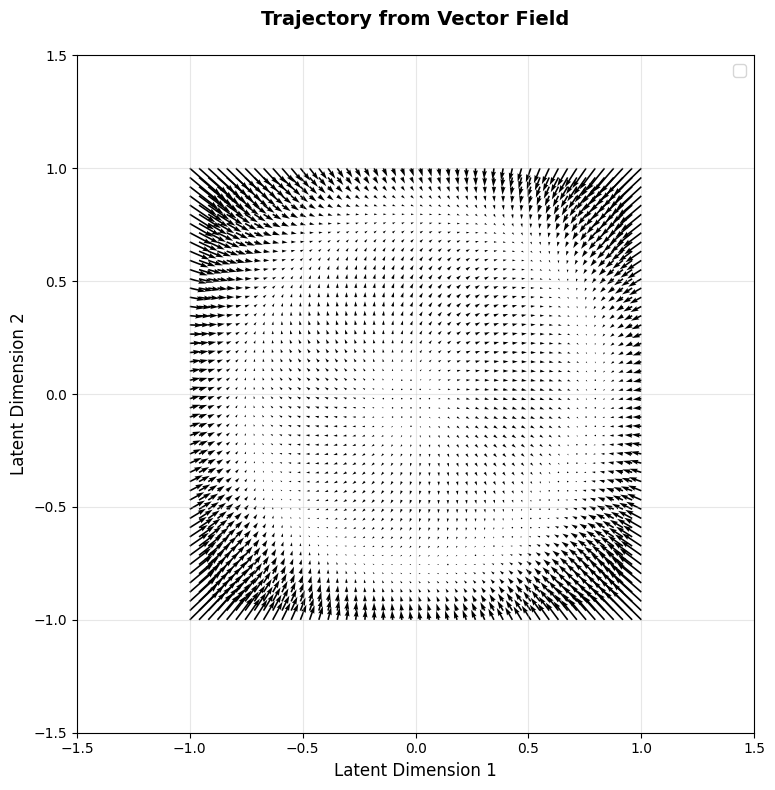

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_box_aspect(1.0)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_title("Trajectory from Vector Field\n", fontweight='bold', fontsize=14)

# Plot learned vector field
plot_two_d_vector_field(
    ssm.dynamics_mod.mean_fn, ax, min_xy=-1.0, max_xy=1.0
)

# Overlay autonomous trajectories from learned dynamics
# for i in range(5):  # plot subset for clarity
#     ax.plot(z_prd[0, i, :, 0].cpu(), z_prd[0, i, :, 1].cpu(), 
#            lw=1, alpha=0.7, color='red')
#     # Mark starting points
#     ax.scatter(z_prd[0, i, 0, 0].cpu(), z_prd[0, i, 0, 1].cpu(), 
#               s=30, alpha=0.8, color='darkred')

# Plot true ring manifold for reference
# ax.plot(inv_man[:, 0], inv_man[:, 1], 'b-', linewidth=4, alpha=0.9, label='True Ring Manifold')

ax.set_xlabel('Latent Dimension 1', fontsize=12)
ax.set_ylabel('Latent Dimension 2', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📈 Training Curves for Key Models

📈 Detailed training curves for key models:
   λ = 1.00e+03


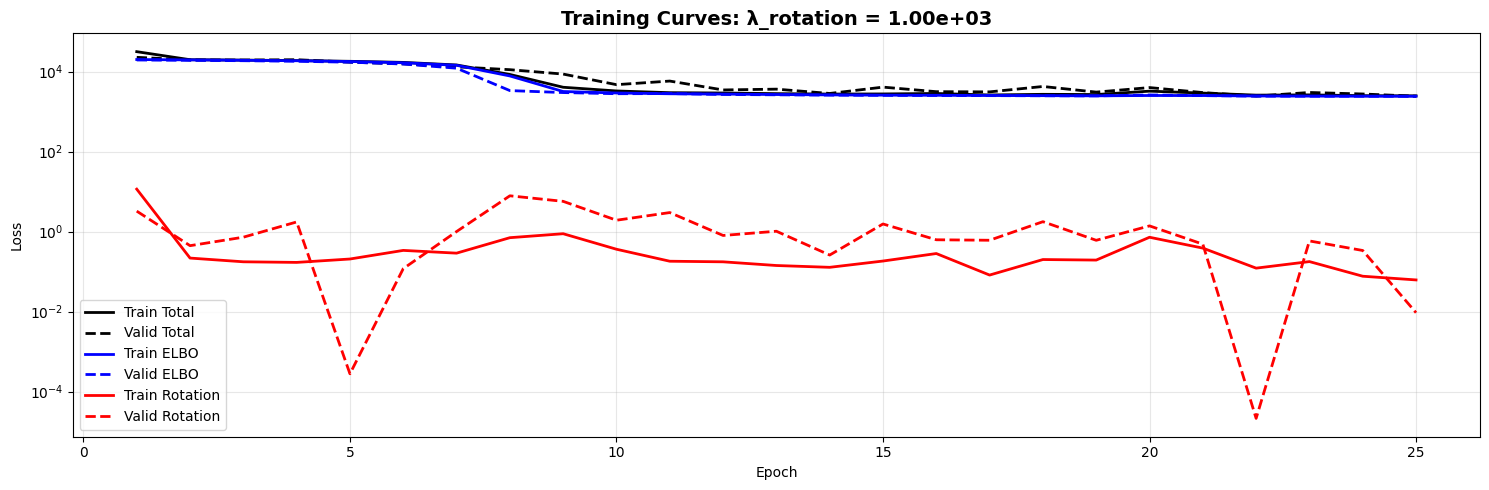

📈 Detailed training curves saved as 'rotation_training_curves.png'


In [17]:
# Show detailed training curves for interesting lambda values
key_lambdas = [lambda_values[-1]]

print(f"📈 Detailed training curves for key models:")
for lambda_val in key_lambdas:
    print(f"   λ = {lambda_val:.2e}")

fig, axes = plt.subplots(len(key_lambdas), 1, figsize=(15, 5*len(key_lambdas)))
if len(key_lambdas) == 1:
    axes = [axes]

for i, lambda_val in enumerate(key_lambdas):
    log = rotation_logs[lambda_val]
    ax = axes[i]
    
    epochs = log['epochs']
    
    # Plot loss curves
    ax.semilogy(epochs, log['train_total_loss'], 'k-', label='Train Total', linewidth=2)
    ax.semilogy(epochs, log['valid_total_loss'], 'k--', label='Valid Total', linewidth=2)
    ax.semilogy(epochs, log['train_elbo_loss'], 'b-', label='Train ELBO', linewidth=2)
    ax.semilogy(epochs, log['valid_elbo_loss'], 'b--', label='Valid ELBO', linewidth=2)
    
    if lambda_val > 0:
        ax.semilogy(epochs, log['train_reg_loss'], 'r-', label='Train Rotation', linewidth=2)
        ax.semilogy(epochs, log['valid_reg_loss'], 'r--', label='Valid Rotation', linewidth=2)
    
    ax.set_title(f'Training Curves: λ_rotation = {lambda_val:.2e}', fontweight='bold', fontsize=14)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('rotation_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("📈 Detailed training curves saved as 'rotation_training_curves.png'")